<a href="https://colab.research.google.com/github/tommycwong/Mask-RCNN_He_Bubbles_Comparison/blob/main/Mask_RCNN_He_Bubbles_Comparison_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask-RCNN Prediction for DL-Based Segmentation of EM Images Containing He Bubbles

Prepared by Tommy (Chun Yin) Wong (cwong13@vols.utk.edu), with data provided by Shradha Agarwal

Supplementary notebook for *Comparing U-Net and Mask-RCNN Algorithms for Deep Learning-Based Segmentation of Electron Microscopy Images Containing Helium Bubbles and Voids for Nuclear Reactor Applications*. This notebook performs instance segmentation of He bubble EM images using a trained Mask R-CNN model.

To run this notebook, click Runtime -> Run all, and in Change runtime type slect a GPU.

Import modules:

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import colorsys

import os
from google.colab import files, drive

import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
!pip3 install torchmetrics
import torchmetrics
from torchmetrics import classification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.4 MB/s eta 0:00:00


In [ ]:
# upgrade gdown
!pip3 install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
# define a function for normalization
def norm2D(img):
    return (img - np.amin(img))/np.ptp(img)

Download images:

In [ ]:
# images
# 100kX_300kV_0537_7_1_mask.png
# 100kX_300kV_0537_11_0_mask.png
# 100kX_300kV_0537_10_3_mask.png
# 100kX_300kV_0537_15_3_mask.png
!gdown --fuzzy https://drive.google.com/file/d/1pOD_DlEb5K8NDMdNrfUJbE4w7gupdPvr/view?usp=share_link
!gdown --fuzzy https://drive.google.com/file/d/1cZRIBaXV37isWu0kpgTVasBb5PDhTX0z/view?usp=share_link
!gdown --fuzzy https://drive.google.com/file/d/1gK2_Q0gjanb0Ndd2jP4xG-tjUSBoBUTm/view?usp=share_link
!gdown --fuzzy https://drive.google.com/file/d/197QSAqnkJxb6puq12QPRY9_c1lEzKLK-/view?usp=share_link

# masks
!gdown --fuzzy https://drive.google.com/file/d/1FVX2wyO9DWR781tTLVrRYOVEyxCKAgHR/view?usp=share_link
!gdown --fuzzy https://drive.google.com/file/d/1ZrN51Z1QsFSyxKM5dtdlGqoRLBOsvXxk/view?usp=share_link
!gdown --fuzzy https://drive.google.com/file/d/18cDr7vk2Iqw4SRFsnNo3jOqF6M5KeEUe/view?usp=share_link
!gdown --fuzzy https://drive.google.com/file/d/1HjzMeW4JCCWm7ujcueVxuu7G6vsfcHWF/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=1pOD_DlEb5K8NDMdNrfUJbE4w7gupdPvr
To: /content/100kX_300kV_0537_7_1.png
100% 159k/159k [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cZRIBaXV37isWu0kpgTVasBb5PDhTX0z
To: /content/100kX_300kV_0537_11_0.png
100% 162k/162k [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gK2_Q0gjanb0Ndd2jP4xG-tjUSBoBUTm
To: /content/100kX_300kV_0537_10_3.png
100% 159k/159k [00:00<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=197QSAqnkJxb6puq12QPRY9_c1lEzKLK-
To: /content/100kX_300kV_0537_15_3_mask.png
100% 6.07k/6.07k [00:00<00:00, 22.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FVX2wyO9DWR781tTLVrRYOVEyxCKAgHR
To: /content/100kX_300kV_0537_7_1_mask.png
100% 4.97k/4.97k [00:00<00:00, 19.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZrN51Z1QsFSyxKM5dtdlGqoRLBOsvXxk
To: /content/100kX_300kV_0537_11_0_mask.png
100% 5.33k/5.33k [00:00<00:00, 18.4MB/s]


Download Mask R-CNN model:

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/10jjNMO3v0pcUUx-B9K_HrLTZFg03KhGf/view?usp=share_link # ieeeMRCNN32layers_epochs50_pretrained.pt

Downloading...
From (uriginal): https://drive.google.com/uc?id=10jjNMO3v0pcUUx-B9K_HrLTZFg03KhGf
From (redirected): https://drive.google.com/uc?id=10jjNMO3v0pcUUx-B9K_HrLTZFg03KhGf&confirm=t&uuid=b7e704a4-c6c6-47fa-9b1b-500c5186b8a0
To: /content/ieeeMRCNN32layers_epochs50_pretrained.pt
100% 183M/183M [00:02<00:00, 61.2MB/s]


Choose an image:

In [ ]:
img_list = ['100kX_300kV_0537_7_1', '100kX_300kV_0537_11_0', '100kX_300kV_0537_10_3', '100kX_300kV_0537_15_3']

In [ ]:
test_imgs = []
for img in img_list:
    test_imgs.append(norm2D(plt.imread(f'{img}.png')))

test_labs = []
for lab in img_list:
    test_labs.append(norm2D(plt.imread(f'{lab}_mask.png')).astype(int))

Define a function for the model:

In [ ]:
def get_instance_segmentation_model(hidden_layer=32, num_classes=2):
    # load an instance segmentation model pre-trained on COCO
    # v2 is a newer version

    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
        pretrained=True, box_detections_per_img=1000)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

Load a trained model for prediction:

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer=32)
# move model to the right device
model.to(device)
model.load_state_dict(torch.load('ieeeMRCNN32layers_epochs50_pretrained.pt', map_location=device))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:03<00:00, 57.7MB/s]


<All keys matched successfully>

Define a function for prediction:

In [ ]:
def MRCNNpred(image):
    model.eval()
    with torch.no_grad():
        prediction = model([torch.as_tensor(image[None, ...], dtype=torch.float32).to(device)])
    return prediction

In [ ]:
def BubbleDetector(test_image=None, wsize=256, pad=64, score_thresh=.7, b=2, exclude_partial=True):
    # b = 2 since image has a 2 px wide border
    swsize = int(wsize-(2*pad))  # selecting window size
    orig_imsize = np.shape(test_image)[0]
    padded_img = np.zeros((orig_imsize+pad*2, orig_imsize+pad*2))
    padded_img[pad:orig_imsize+pad, pad:orig_imsize+pad] = test_image
    imsize = np.shape(padded_img)[0]
    pred_entire_image = np.zeros((imsize,imsize))

    x0 = 0; y0 = 0
    scores = np.array([]); boxes = np.zeros((1, 4))
    masks = np.zeros((1, orig_imsize, orig_imsize))
    for y in range(int(imsize/wsize*2-1)):
        y0 = swsize * y
        for x in range(int(imsize/wsize*2-1)):
            x0 = swsize * x
            window = padded_img[y0:y0+wsize, x0:x0+wsize]
            window_pred = MRCNNpred(window)[0]
            boxes_np = window_pred['boxes'].cpu().numpy()
            # find valid boxes within [64, 192[
            midpts = np.array([(boxes_np[:, 0]+boxes_np[:, 2])/2, (boxes_np[:, 1]+boxes_np[:, 3])/2]).T
            valid_midptsBM = (((pad<=midpts[:,0])==(midpts[:,0]<pad+swsize)).astype(int)+((pad<=midpts[:,1])==(midpts[:,1]<pad+swsize)).astype(int)) == 2 # both are true
            # find valid scores
            valid_scoresBM = window_pred['scores'].cpu().numpy() > score_thresh

            if exclude_partial == False:
                # find valid objects
                valid_idx = (valid_midptsBM.astype(int)+valid_scoresBM.astype(int)) == 2  # both are true
            else:
                # find objects not on edges
                valid_boxBMx = []; valid_boxBMy = []; valid_boxBM = []
                if x0 == 0:
                    valid_boxBMx = boxes_np[:,0]>pad+b
                    valid_boxBM = valid_boxBMx
                elif x0 == swsize*int(imsize/wsize*2-2):
                    valid_boxBMx = boxes_np[:,2]<wsize-pad-b
                    valid_boxBM = valid_boxBMx
                if y0 == 0:
                    valid_boxBMy = boxes_np[:,1]>pad+b
                    valid_boxBM = valid_boxBMy
                elif y0 == swsize*int(imsize/wsize*2-2):
                    valid_boxBMy = boxes_np[:,3]<wsize-pad-b
                    valid_boxBM = valid_boxBMy
                if len(valid_boxBMx) != 0 and len(valid_boxBMy) != 0:
                    valid_boxBM = (valid_boxBMx.astype(int)+valid_boxBMy.astype(int)) == 2
                # find valid objects
                if len(valid_boxBM) != 0:
                    valid_idx = (valid_midptsBM.astype(int)+valid_scoresBM.astype(int)+valid_boxBM.astype(int)) == 3  # all are true
                else:
                    valid_idx = (valid_midptsBM.astype(int)+valid_scoresBM.astype(int)) == 2 # both are true

            valid_scores = window_pred['scores'].cpu().numpy()[valid_idx]
            valid_boxes = window_pred['boxes'].cpu().numpy()[valid_idx]
            # calculate coords in padded image
            valid_boxes[:, [0, 2]] = valid_boxes[:, [0, 2]] + x0    # x1, x2
            valid_boxes[:, [1, 3]] = valid_boxes[:, [1, 3]] + y0    # y1, y2
            # calculate coords in original image
            valid_boxes = valid_boxes - pad
            # place the mask in padded image
            valid_masks = window_pred['masks'].cpu().numpy()[valid_idx][:, 0, ...]
            valid_masks_large = np.zeros((len(valid_scores), imsize, imsize))
            valid_masks_large[:, y0:y0+wsize, x0:x0+wsize] = valid_masks
            # crop mask to shape of original image
            valid_masks_large = valid_masks_large[:, pad:orig_imsize+pad, pad:orig_imsize+pad]

            scores = np.append(scores, valid_scores)
            boxes = np.concatenate((boxes, valid_boxes), axis=0)
            masks = np.concatenate((masks, valid_masks_large), axis=0)

    return {'id':[*range(len(scores))], 'scores':scores, 'boxes':boxes[1:, ...], 'masks':masks[1:, ...]}

Perform prediction:

In [ ]:
results_list = []
pred_labs = []
for img in test_imgs:
    results = BubbleDetector(img, wsize=512, pad=0, score_thresh=.9, b=0, exclude_partial=False)
    results_list.append(results)
    pred_mono = np.sum(results['masks'], axis=0)
    pred_mono[pred_mono > .5] = 1
    pred_mono[pred_mono <= .5] = 0
    pred_labs.append(pred_mono.astype(int))

Perform comparison:

In [ ]:
comparisons = []
for i in range(len(pred_labs)):
    diff = np.abs(pred_labs[i]-test_labs[i])
    superim = test_imgs[i] + diff
    superim[superim > 1] = 1
    comparisons.append(superim)

In [ ]:
# create color labels
color_labs = []
for j in range(len(results_list)):
    num_preds = len(results_list[j]['id'])
    height = results_list[j]['masks'].shape[1]; width = results_list[j]['masks'].shape[2]
    colourmasks = np.zeros((num_preds, height, width, 3))
    hues = np.linspace(0.01, 0.99, num_preds)
    rng = np.random.default_rng(seed=41)
    hues = rng.permuted(hues)

    for i in range(num_preds):
        mask_i = results_list[j]['masks'][i]
        mask_i[mask_i > .5] = 1
        mask_i[mask_i <= .5] = 0
        colorRGB = colorsys.hsv_to_rgb(hues[i], 1., 1.)
        mask3d_i = np.full((mask_i.shape[0], mask_i.shape[1], 3), mask_i[..., None])
        mask3d_i[..., 0] = mask3d_i[..., 0] * colorRGB[0]
        mask3d_i[..., 1] = mask3d_i[..., 1] * colorRGB[1]
        mask3d_i[..., 2] = mask3d_i[..., 2] * colorRGB[2]
        colourmasks[i] = mask3d_i
    pred_color = norm2D(np.sum(colourmasks, axis=0))
    color_labs.append(pred_color)

Display identification and comparison. The columns correspond as follows: original image, Mask R-CNN identification, ground truth, comparison.

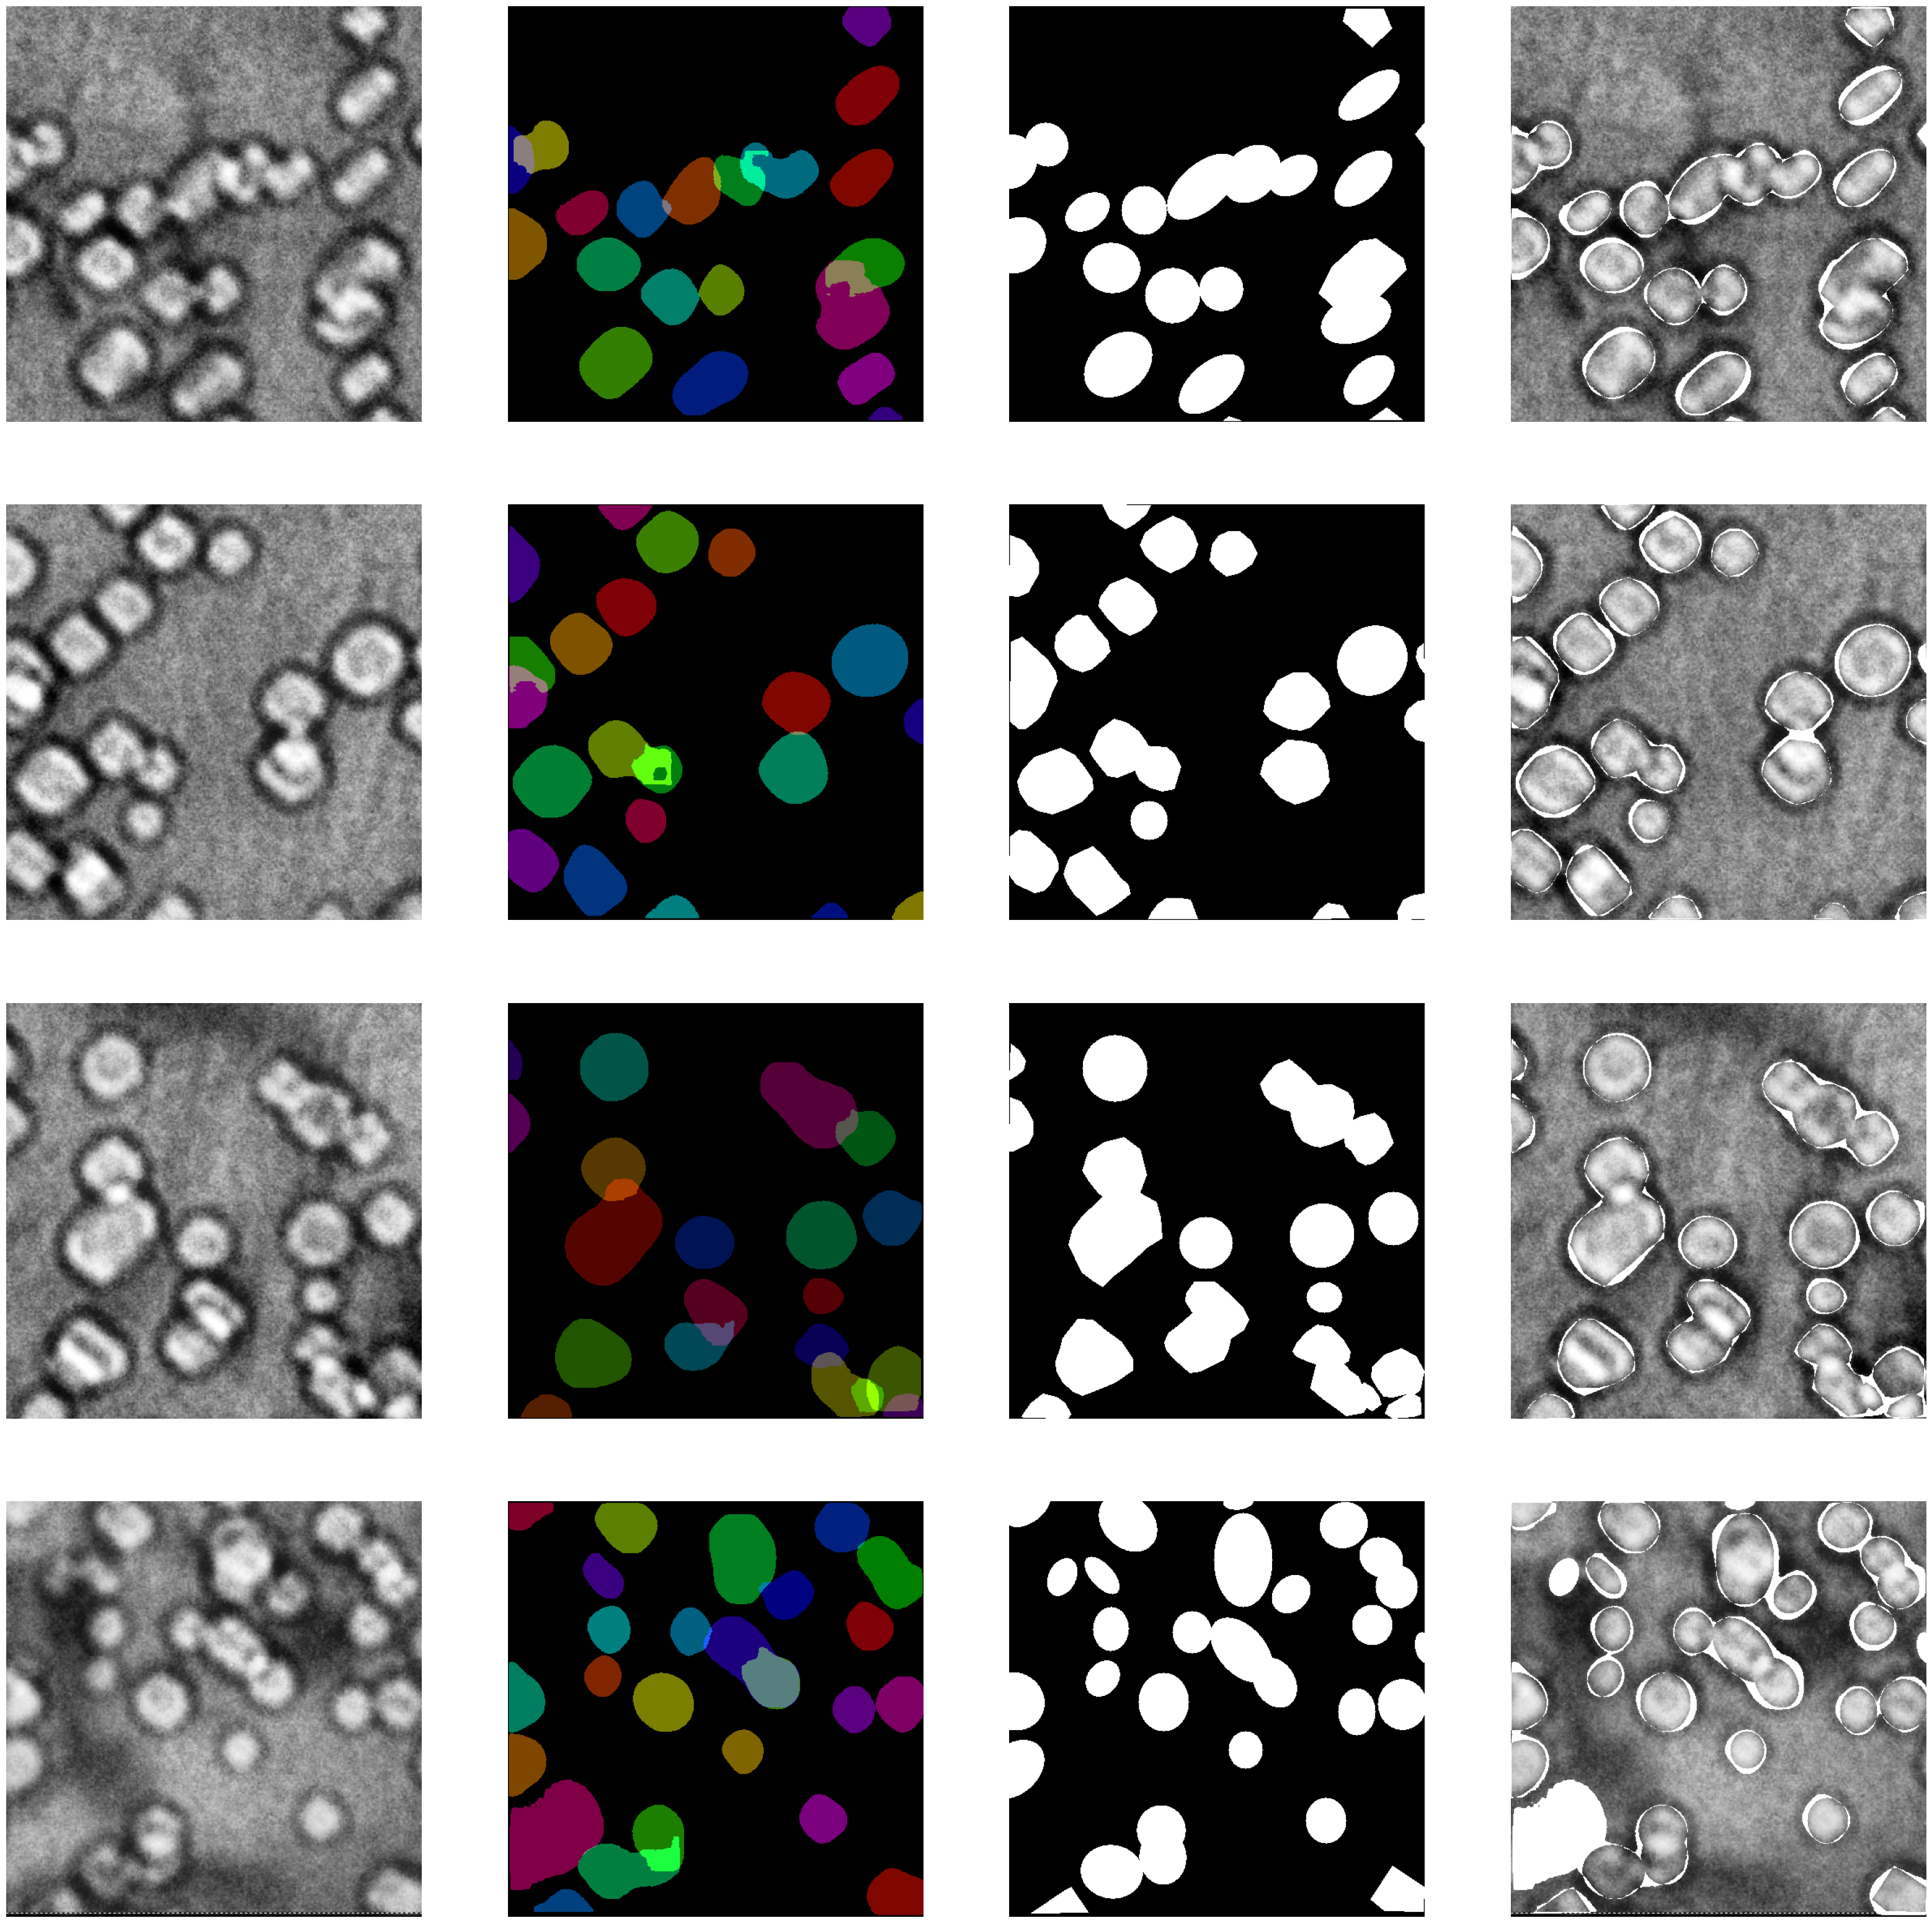

In [ ]:
# display comparison
fig1, ax = plt.subplots(4, 4, figsize=(40, 40))
for i in range(4):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 0].imshow(test_imgs[i], cmap='gist_gray')
    ax[i, 1].imshow(color_labs[i])
    ax[i, 2].imshow(test_labs[i], cmap='gist_gray')
    ax[i, 3].imshow(comparisons[i], cmap='gist_gray')

Save figure:

In [ ]:
#drive.mount('/content/drive')
#os.chdir('your_directory')
#fig1.savefig('results', bbox_inches='tight')

Calculate metrics:

In [ ]:
pred_labs_t = torch.as_tensor(np.dstack(pred_labs))
train_labs_t = torch.as_tensor(np.dstack(test_labs))

In [ ]:
# print metrics
metric = classification.BinaryAccuracy()
print('Pixelwise accuracy: ', metric(pred_labs_t, train_labs_t))
metric = classification.BinaryJaccardIndex()
print('IoU: ', metric(pred_labs_t, train_labs_t))
metric = classification.BinaryRecall()
print('Recall: ', metric(pred_labs_t, train_labs_t))
metric = classification.BinaryPrecision()
print('Precision: ', metric(pred_labs_t, train_labs_t))
metric = classification.BinaryF1Score()
print('F1: ', metric(pred_labs_t, train_labs_t))
metric = torchmetrics.Dice()
print('Dice: ', metric(pred_labs_t, train_labs_t))
metric = torchmetrics.MeanAbsoluteError()
print('Mean Absolute Error: ', metric(pred_labs_t, train_labs_t))

Pixelwise accuracy:  tensor(0.9432)
IoU:  tensor(0.8062)
Recall:  tensor(0.9717)
Precision:  tensor(0.8255)
F1:  tensor(0.8927)
Dice:  tensor(0.9432)
Mean Absolute Error:  tensor(0.0568)
